##### 규제 선형 모델
- 다항식이 복잡해지면서 회귀계수값 크게 설정됨, 과대적합 유발
 -> 훈련 데이터에선 높은 성능 but 테스트 데이터에서는 낮은 성능 보임

- 선형 모델의 목적: 비용 함수 최소화
- 이때 규제 선형 모델은 비용 함수를 최소화 하는 데에 패널티(alpha)를 적용해 회귀계수의 크기 제한함

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##### Ridge 회귀
- L2 규제를 적용한 회귀 모델
- 회귀 계수들의 제곱합에 alpha 패널티를 곱해 비용함수값 산정에 반영

In [5]:
from sklearn.model_selection import train_test_split

boston_df = pd.read_csv('./data/boston_housing_train.csv')

X = boston_df.drop('MEDV', axis=1)
y = boston_df['MEDV']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
# 다른 평가 지표 사용
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

def evaluate_regression(y_true, y_pred):
    #mse
    mse = mean_squared_error(y_true, y_pred)
    #rmse
    rmse = root_mean_squared_error(y_true, y_pred)
    #mae
    mae = mean_absolute_error(y_true, y_pred)
    #r2
    r2 = r2_score(y_true, y_pred)

    print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R2:{r2}')


In [10]:
# 릿지 회귀
from sklearn.linear_model import Ridge
reg = Ridge(alpha=1000)
# 규제 강도 lambda 설정

reg.fit(X_train, y_train)
print(reg.score(X_test, y_test), reg.score(X_train, y_train))
# alpha = 1일 때 (0.678974832784608, 0.7461161787884155)
# alpha = 10일 때 (0.6724237562438147 0.7398240895568371)
# alpha = 1000일 때 (0.6378962987850003 0.6659274317723316) -> train과 test가 비슷하므로 과적합은 해결.
 
print(reg.coef_) # 가중치 출력

0.6378962987850003 0.6659274317723316
[-0.11061359  0.03585601 -0.03547767  0.09054954 -0.00715045  0.51470729
  0.02815722 -0.49486087  0.26292369 -0.01344429 -0.6079847   0.01144887
 -0.79222816]


In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
# 일련의 파이프라인 동작을 가능케 함

model = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('reg', Ridge(alpha=800))
    # 이름이 될 문자열, 객체 지정
    # 파이프라인이라는 하나의 객체에 모델들을 각각의 객체로 넣음

    # 순차적으로 실행하므로 순서 바뀌면 안 됨.
])

model.fit(X_train, y_train)
print(model.score(X_train, y_train), model.score(X_test, y_test))
# 0.934045449915728 0.7735821268700346

evaluate_regression(y_test, model.predict(X_test))
# MSE: 15.855396927570286, RMSE: 3.981883590409228, MAE: 2.490640641202681, R2:0.7735821268700346

0.9097244711884594 0.8097352558923421
MSE: 13.323696567973178, RMSE: 3.650163909740654, MAE: 2.4729072941162915, R2:0.8097352558923421


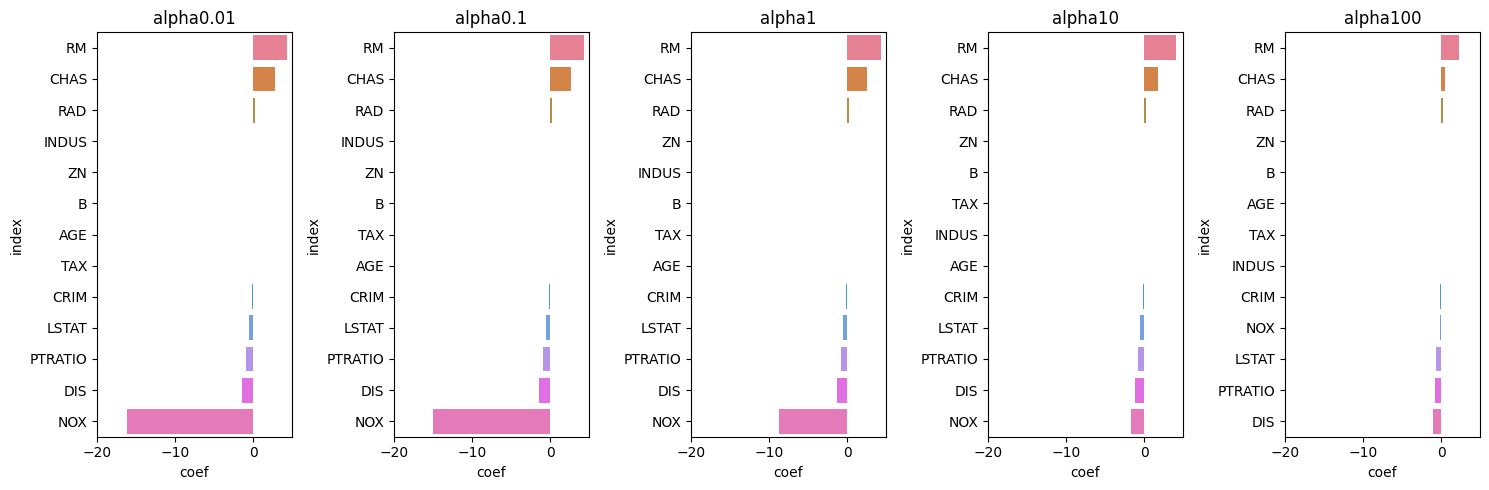

In [ ]:
# alpha값에 따른 변화 시각화
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))

alphas = [0.01, 0.1, 1, 10, 100]

for i, alpha in enumerate(alphas):
    rmodel = Ridge(alpha=alpha)
    rmodel.fit(X_train, y_train)

    coef = rmodel.coef_
    coef_ser = pd.Series(coef, index =X.columns)
    coef_ser.name = 'alpha'+str(alpha)
    coef_ser = coef_ser.sort_values(ascending=False)

    ax[i].set_title(coef_ser.name)
    ax[i].set_xlabel('coef')
    ax[i].set_ylabel('index')
    ax[i].set_xlim(-20, 5)

    sns.barplot(x=coef_ser.values, y=coef_ser.index, ax=ax[i], hue=coef_ser.index)

plt.tight_layout()
# layout에 알맞게 표시(안 하면 x, y 축 라벨이 다른 표에 침범하고 그럼)
plt.show()

##### 라쏘 회귀
- L1 규제를 적용한 선형 회귀 모델
- 회귀계수의 절댓값 합을 alpha 패널티와 곱해 규제 정도를 지정함
- 회귀계수를 0까지 줄일 수 있음 -> 해당 특성을 아예 반영하지 않도록 함 -> 특성 선택 효과가 있음

In [ ]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=10)

reg.fit(X_train, y_train)

print(reg.score(X_train, y_train), reg.score(X_test, y_test))
# 0.5373948270602298 0.49459972513091244 -> 과소적합.
print(reg.coef_)
# 가중치를 0.1에서 10으로 키우니 가중치 중 여러 개가 0값이 나옴. 0이 많은 건 좋지만 과소적합 나왔으므로 적합 X



0.5373948270602298 0.49459972513091244
[-0.          0.00806625 -0.          0.          0.          0.
  0.         -0.          0.         -0.00896833 -0.          0.01014021
 -0.62986968]


##### ElasticNet 회귀
- L1, L2 규제를 함께 적용할 수 있는 회귀 모델

**하이퍼 파라미터**
- alpha: 규제 정도 (L1+L2)
- l1_ratio: alpha 값 중 L1 규제의 비율(0~1) 기본값은 0.5

In [ ]:
from sklearn.linear_model import ElasticNet

reg = ElasticNet(alpha=10, l1_ratio=0.2)

reg.fit(X_train, y_train)

print(reg.score(X_train, y_train), reg.score(X_test, y_test))
# 0.582267021479868 0.5515443461890219

print(reg.coef_)
# alpha값은 아까 라쏘 때와 같으나 0이 된 가중치 수가 적음.

0.582267021479868 0.5515443461890219
[-0.04757351  0.0297799  -0.          0.          0.          0.01006149
  0.0263796  -0.01728823  0.0623326  -0.00926173 -0.19693406  0.01084713
 -0.69194846]


In [ ]:
# Pipeline 사용 -> degree=3 특성 확장 -> ElasticNet
model2 = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False, degree=3)),
    ('reg', ElasticNet(alpha=1000, l1_ratio=0.3))
])

# 학습 -> 평가 -> evaluate_regression()으로 평가 지표 출력
model2.fit(X_train, y_train)
print(model2.score(X_train, y_train), model2.score(X_test, y_test))
# 0.9144465191159602 0.8158595182436122
# 규제 적용하니 train데이터에 대해 성능 3점 내려가는 대신 test데이터 성능 4점 오름 -> 과적합 해결!
evaluate_regression(y_test, model2.predict(X_test))


0.9144465191159602 0.8158595182436122
MSE: 12.894831968524235, RMSE: 3.5909374776685037, MAE: 2.3570310718688567, R2:0.8158595182436122


c:\Users\Playdata\AppData\Local\anaconda3\envs\ml_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e+03, tolerance: 3.361e+00
  model = cd_fast.enet_coordinate_descent(


In [ ]:
reg = model2.named_steps['reg']
# 단계별로 있는 객체를 딕셔너리 형태로 출력. key는 모델 이름. key를 참조하는 것처럼 대괄호로 쓰면 그 모델 객체를 반환함

print(reg.coef_, reg.intercept_)
# alpha를 크게 줬으므로 0인 특성이 많음.

[ 0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000